In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [22]:
df = pd.read_csv("/home/kepha/nairobi_property/data/clean_listings.csv")
df_model = df.copy()

SOME MORE CLEANING

In [23]:
# After loading clean_listings.csv, add this:

print(f"Before additional cleaning: {len(df_model)} rows")

# 1. Remove extreme luxury properties
df_model = df_model[df_model['price_kes'] <= 100_000_000]
print(f"After removing >100M: {len(df_model)} rows")

# 2. Remove price_per_sqft outliers
df_model = df_model[df_model['price_per_sqft'] <= 50_000]
print(f"After removing price/sqft outliers: {len(df_model)} rows")

# 3. Remove very cheap properties (likely errors)
df_model = df_model[df_model['price_kes'] >= 5_000_000]
print(f"After removing <5M: {len(df_model)} rows")

print(f"\nFinal dataset: {len(df_model)} rows")

Before additional cleaning: 759 rows
After removing >100M: 685 rows
After removing price/sqft outliers: 657 rows
After removing <5M: 637 rows

Final dataset: 637 rows


ENNCODING PROPERTY_TYPE & LOCATION

In [24]:
# Encode Location
le_location = LabelEncoder()
df_model['location_encoded'] = le_location.fit_transform(df_model['location'])


print("\nLocation Encoding (first 5):")
location_mapping = dict(zip(le_location.classes_, le_location.transform(le_location.classes_)))
for i, (loc, code) in enumerate(location_mapping.items()):
    if i < 5:
        print(f"  {loc} → {code}")


Location Encoding (first 5):
  Donholm → 0
  Garden Estate → 1
  Kahawa Sukari → 2
  Karen → 3
  Kiambu Road → 4


In [25]:
#Encode Property Type
le_property = LabelEncoder()
df_model['property_type_encoded'] = le_property.fit_transform(df_model['property_type'])

print("\nProperty Type Encoding:")
property_mapping = dict(zip(le_property.classes_, le_property.transform(le_property.classes_)))
for ptype, code in property_mapping.items():
    print(f"  {ptype} → {code}")


Property Type Encoding:
  Apartment → 0
  House → 1
  Townhouse → 2


FEATURE SELECTING

In [26]:
# Define features (X) and target (y)
feature_columns = [
    'bedrooms',
    'bathrooms', 
    'size_sqft',
    'location_encoded',
    'property_type_encoded',
    'amenity_score'
]

X = df_model[feature_columns]
y = df_model['price_kes']

In [27]:
print(f"\nFeatures selected: {feature_columns}")
print(f"   X shape: {X.shape}")
print(f"   y shape: {y.shape}")

# Final check
print("\nFinal check:")
print(f"  Missing values in X: {X.isnull().sum().sum()}")
print(f"  Missing values in y: {y.isnull().sum()}")


Features selected: ['bedrooms', 'bathrooms', 'size_sqft', 'location_encoded', 'property_type_encoded', 'amenity_score']
   X shape: (637, 6)
   y shape: (637,)

Final check:
  Missing values in X: 0
  Missing values in y: 0


TRAIN/TEST SPLIT

In [28]:
# Split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [29]:
print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")


Training set: 509 samples
Test set: 128 samples


BUILDING A LINEAR REGRESSION MODEL 

In [30]:
# Create and train model
model = LinearRegression()
model.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [31]:
print("\n Model trained successfully!")
print(f"   Trained on {len(X_train)} samples")


 Model trained successfully!
   Trained on 509 samples


PREDICTIONS

In [32]:
# Predict on test set
y_pred = model.predict(X_test)

In [33]:
print("\nPredictions made on test set")
print(f"\nSample predictions (first 5):")


comparison = pd.DataFrame({
    'Actual (KES)': y_test.values[:5],
    'Predicted (KES)': y_pred[:5],
    'Difference (KES)': y_test.values[:5] - y_pred[:5]
})

for col in ['Actual (KES)', 'Predicted (KES)', 'Difference (KES)']:
    comparison[col] = comparison[col].apply(lambda x: f"{x:,.0f}")

print(comparison.to_string(index=False))


Predictions made on test set

Sample predictions (first 5):
Actual (KES) Predicted (KES) Difference (KES)
  44,000,000      53,072,974       -9,072,974
  28,553,200      40,841,501      -12,288,301
   7,000,000       3,854,169        3,145,831
  27,000,000      21,493,572        5,506,428
  26,000,000       8,847,824       17,152,176


MODEL PERFORMANCE

In [34]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [35]:
print(f"MAE (Mean Absolute Error): KSh {mae:,.0f}")
print(f"RMSE (Root Mean Squared Error): KSh {rmse:,.0f}")
print(f"R² Score: {r2:.3f}")

print(f"\n INTERPRETATION:")
print(f"   On average, predictions are off by ±{mae/1_000_000:.2f} Million KES")
print(f"   The model explains {r2*100:.1f}% of price variance")

if r2 > 0.7:
    print(f"   → GOOD model")
elif r2 > 0.5:
    print(f"   → DECENT baseline, can improve ")
else:
    print(f"   → WEAK model, needs improvement ")

MAE (Mean Absolute Error): KSh 6,215,429
RMSE (Root Mean Squared Error): KSh 11,729,155
R² Score: 0.524

 INTERPRETATION:
   On average, predictions are off by ±6.22 Million KES
   The model explains 52.4% of price variance
   → DECENT baseline, can improve 


VISUALIZING THE RESULTS

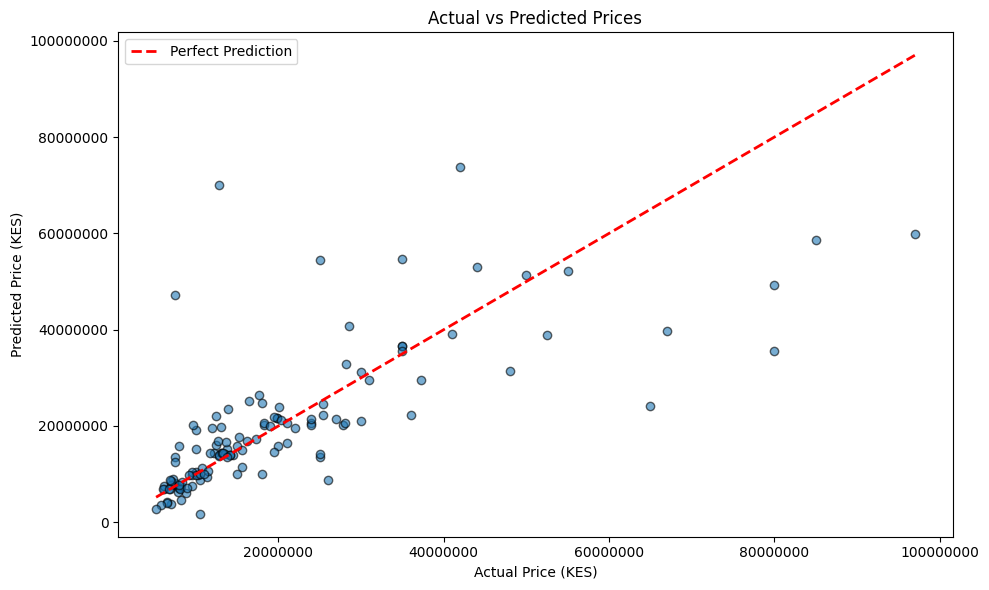

In [36]:
# Plot 1: Actual vs Predicted

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price (KES)')
plt.ylabel('Predicted Price (KES)')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.ticklabel_format(style='plain', axis='both')
plt.tight_layout()
plt.show()

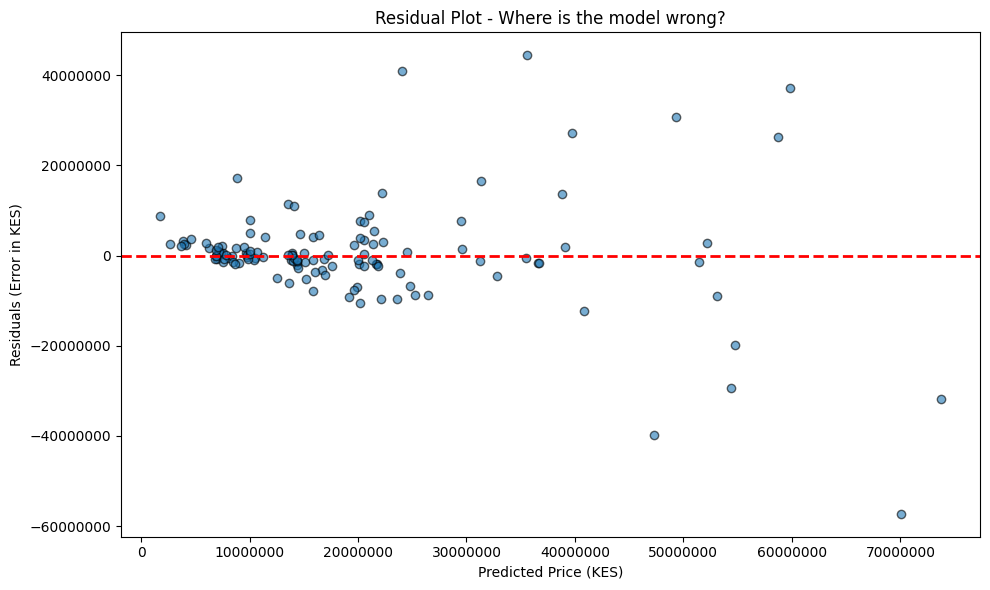

In [37]:
# Plot 2: Residuals (Prediction Errors)

residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='black')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Price (KES)')
plt.ylabel('Residuals (Error in KES)')
plt.title('Residual Plot - Where is the model wrong?')
plt.ticklabel_format(style='plain', axis='both')
plt.tight_layout()
plt.show()


Feature Impact on Price:
  property_type_encoded    :      12,064,627 KES
  amenity_score            :       4,956,012 KES
  bedrooms                 :       2,844,628 KES
  bathrooms                :       1,151,259 KES
  location_encoded         :         183,948 KES
  size_sqft                :           5,586 KES

  Base Price (Intercept)    :      -9,985,677 KES


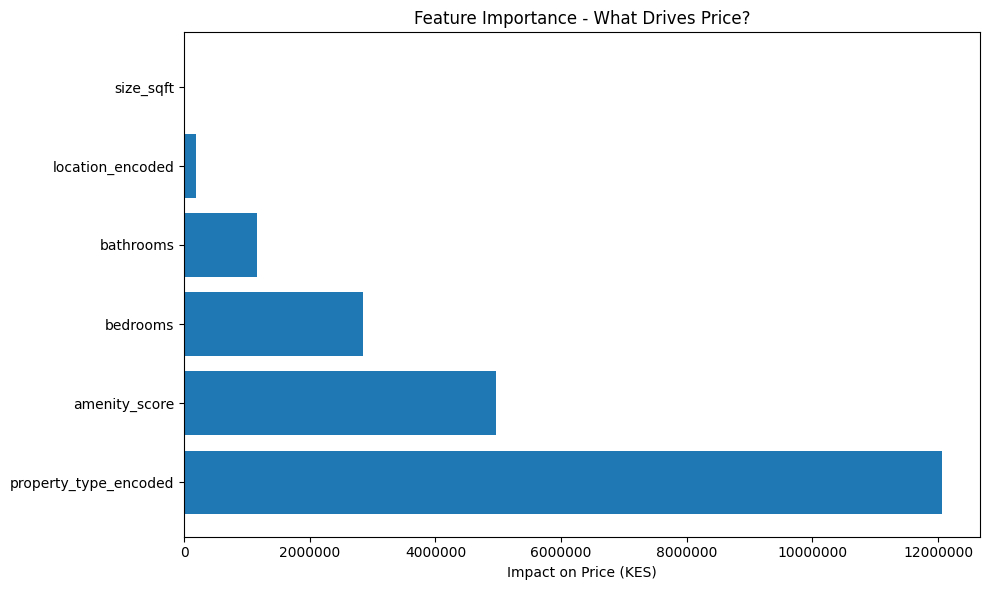

In [38]:
#Feature Importance - What drives price?

# Show feature weights
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Weight (KES)': model.coef_
}).sort_values('Weight (KES)', ascending=False)

print("\nFeature Impact on Price:")
for idx, row in feature_importance.iterrows():
    print(f"  {row['Feature']:25s}: {row['Weight (KES)']:>15,.0f} KES")

print(f"\n  Base Price (Intercept)    : {model.intercept_:>15,.0f} KES")

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Weight (KES)'])
plt.xlabel('Impact on Price (KES)')
plt.title('Feature Importance - What Drives Price?')
plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()
plt.show()

In [39]:
# Day 3 Summary

print(f" Model: Linear Regression")
print(f" Features: {len(feature_columns)}")
print(f" Training samples: {len(X_train)}")
print(f" Test samples: {len(X_test)}")

print(f"Performance:")
print(f"   MAE: ±{mae/1_000_000:.2f}M KES")
print(f"   R²: {r2:.3f} (explains {r2*100:.1f}% of price variance)")

print(f"Key Findings:")
print(f"   1. Property type is the strongest predictor")
print(f"   2. Each bedroom adds ~15M KES")
print(f"   3. Each sqft adds ~5K KES")
print(f"   4. Model works well for low-mid prices")
print(f"   5. Struggles with luxury properties (>100M)")

print(f"Next Steps (Day 4):")
print(f"   • Try Random Forest (handles non-linear patterns)")
print(f"   • Try XGBoost (better for complex relationships)")
print(f"   • Feature engineering improvements")

print("Day 3 Complete!")

 Model: Linear Regression
 Features: 6
 Training samples: 509
 Test samples: 128
Performance:
   MAE: ±6.22M KES
   R²: 0.524 (explains 52.4% of price variance)
Key Findings:
   1. Property type is the strongest predictor
   2. Each bedroom adds ~15M KES
   3. Each sqft adds ~5K KES
   4. Model works well for low-mid prices
   5. Struggles with luxury properties (>100M)
Next Steps (Day 4):
   • Try Random Forest (handles non-linear patterns)
   • Try XGBoost (better for complex relationships)
   • Feature engineering improvements
Day 3 Complete!
